# 机器学习进阶毕业项目—驾驶员状态检测

## 一、数据处理

### 1、调整图片大小，将其从原始640x480调整为224x224，以便用于基础模型vgg-16

In [2]:
import cv2
def get_im_cv2(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
    return resized

### 2、从driver-image-list中获取每张图片对应的驾驶员信息。

In [3]:
import os
def get_driver_data():
    dr = dict()
    clss = dict()
    path = os.path.join( 'input', 'driver_imgs_list.csv')
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
        if arr[0] not in clss.keys():
            clss[arr[0]] = [(arr[1], arr[2])]
        else:
            clss[arr[0]].append((arr[1], arr[2]))
    f.close()
    return dr, clss

### 3、载入训练数据

In [4]:
import glob
import time
def load_train():
    X_train = []
    X_train_id = []
    y_train = []
    driver_id = []
    start_time = time.time()
    driver_data, dr_class = get_driver_data()

    print('Read train images')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join( 'input', 'train', 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im_cv2(fl)
            X_train.append(img)
            X_train_id.append(flbase)
            y_train.append(j)
            driver_id.append(driver_data[flbase])

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return X_train, y_train, X_train_id, driver_id, unique_drivers

### 4、载入测试数据

In [5]:
def split_list(l, wanted_parts=1):
    length = len(l)
    return [l[i*length // wanted_parts: (i+1)*length // wanted_parts] for i in range(wanted_parts)]

In [6]:
def load_test(part):
    path = os.path.join( 'input', 'test', '*.jpg')
    files = sorted(glob.glob(path))
    ch = split_list(files, 5)

    X_test = []
    X_test_id = []
    print('Start image: ' + str(ch[part][0]))
    print('Last image: ' + str(ch[part][-1]))
    for fl in ch[part]:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl)
        X_test.append(img)
        X_test_id.append(flbase)

    return X_test, X_test_id

### 5、缓存、恢复数据

In [7]:
import pickle
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')

In [8]:
def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

### 6、标准化训练数据和测试数据

In [9]:
import numpy as np
#import sys
from numpy.random import permutation
#from convert import blobproto_to_array
def read_and_normalize_train_data():
    cache_path = os.path.join('cache', 'train_r_' + str(224) + '_c_' + str(224) + '_t_' + str(3) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        train_data, train_target, train_id, driver_id, unique_drivers = load_train()
        cache_data((train_data, train_target, train_id, driver_id, unique_drivers), cache_path)
    else:
        print('Restore train from cache!')
        (train_data, train_target, train_id, driver_id, unique_drivers) = restore_data(cache_path)

    print('Convert to numpy...')
    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)

    print('Reshape...')
    train_data = train_data.transpose((0, 3, 1, 2))
    #train_data = train_data.transpose((2,0,1))

    print('Convert to float...')
    train_data = train_data.astype('float16')
    mean_pixel = [103.939, 116.779, 123.68]
    print('Substract 0...')
    train_data[:, 0, :, :] -= mean_pixel[0]
    print('Substract 1...')
    train_data[:, 1, :, :] -= mean_pixel[1]
    print('Substract 2...')
    train_data[:, 2, :, :] -= mean_pixel[2]

    train_target = np_utils.to_categorical(train_target, 10)

    # Shuffle experiment START !!!
    perm = permutation(len(train_target))
    train_data = train_data[perm]
    train_target = train_target[perm]
    # Shuffle experiment END !!!

    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target, train_id, driver_id, unique_drivers

In [10]:
def read_and_normalize_test_data(part):
    start_time = time.time()
    cache_path = os.path.join('cache', 'test_r_' + str(224) +
                              '_c_' + str(224) +
                              '_part_' + str(part) +
                              '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        test_data, test_id = load_test(part)
        cache_data((test_data, test_id), cache_path)
    else:
        print('Restore test from cache [{}]!'.format(part))
        (test_data, test_id) = restore_data(cache_path)

    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.transpose((0, 3, 1, 2))

    test_data = test_data.astype('float16')
    mean_pixel = [103.939, 116.779, 123.68]
    test_data[:, 0, :, :] -= mean_pixel[0]
    test_data[:, 1, :, :] -= mean_pixel[1]
    test_data[:, 2, :, :] -= mean_pixel[2]

    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    print('Read and process test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return test_data, test_id

## 二、创建卷积神经网络模型。

### 1、基于VGG-16构建卷积神经网络。将最后一层1000的全连接层改为10，以针对本项目的十种输出。

#from keras.preprocessing.image import ImageDataGenerator
#from keras import optimizers
#from keras.models import Sequential
#from keras.layers import Dropout, Flatten, Dense
##from keras import Model
#from keras import initializers
#from keras.callbacks import ModelCheckpoint, EarlyStopping
#from keras.applications.vgg16 import VGG16

#from keras.utils import np_utils
#from keras.optimizers import SGD

def VGG_16():
    input_shape=(3, 224, 224)
    
    model = VGG16(input_shape = input_shape, 
                     include_top = True, 
                     classes = 10, 
                     weights = None
                     )
    print('Model loaded.')
    
    model.layers[-1].name = 'pred'
    model.layers[-1].kernel_initializer.get_config()
    model.layers[-1].kernel_initializer = initializers.glorot_normal()
    model.load_weights('weights/vgg16_weights.h5', by_name = True)
    
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return model

In [11]:
#from keras import backend as K
#K.image_data_format('th')

from keras.models import Model
from keras.utils import layer_utils

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.utils import np_utils
from keras.models import model_from_json
import sklearn
from sklearn.metrics import log_loss

from keras import backend as K
#K.set_image_data_format('channels_first')
K.set_image_dim_ordering('th')
#K.set_image_data_format('channels_last')

#from keras.utils.conv_utils import convert_kernel

import h5py
def VGG_16():
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, 224, 224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2), name='block5_pool'))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu',name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
    #model.add(Dense(1000, activation='softmax'))
    
    #model.load_weights('weights/vgg16_weights.h5')
 
    #model.layers.pop()
    #model.outputs = [model.layers[-1].output]
    #model.layers[-1].outbound_nodes = [] 
    #model.add(Dense(10, activation='softmax'))
    
    #maxpool = model.get_layer(name='block5_pool')
    ## model.get_layer()依据层名或下标获得层对象
    #shape = maxpool.output_shape[1:]
    ## 获取block5_pool层输出的数据格式
    #dense = model.get_layer(name='fc1')
    #layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')
    
    
    f = h5py.File('weights/vgg16_weights.h5')
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # we don't look at the last (fully-connected) layers in the savefile
           break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        
        
        #reshaped_weights = convert_kernel(weights)
        #model.layers[k].set_weights(reshaped_weights)
        
        model.layers[k].set_weights(weights)
    
    f.close()
    
    print('Model loaded.')

    model.add(Dense(10, activation='softmax'))

    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy',metrics=['accuracy'])

    return model

Using Theano backend.
Using cuDNN version 7005 on context None
Mapped name None to device cuda: Tesla V100-SXM2-16GB (0000:00:1E.0)
/home/ubuntu/anaconda3/envs/theano_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 2、保存和读取模型。

In [12]:
def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(os.path.join('cache', 'architecture_vgg16.json'), 'w').write(json_string)
    model.save_weights(os.path.join('cache', 'model_weights_vgg16.h5'), overwrite=True)

In [13]:
def read_model():
    model = model_from_json(open(os.path.join('cache', 'architecture_vgg16.json')).read())
    model.load_weights(os.path.join('cache', 'model_weights_vgg16.h5'))
    return model

## 三、训练神经网络

### 1、将验证结果按对应的id存放在字典predictions_valid上，然后将其按对应的顺序转化为列表。

In [14]:
def get_validation_predictions(train_data, predictions_valid):
    pv = []
    for i in range(len(train_data)):
        pv.append(predictions_valid[i])
    return pv

### 2、保存必要的数据。

In [15]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
def save_useful_data(predictions_valid, valid_ids, model, info):
    result1 = pd.DataFrame(predictions_valid, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(valid_ids, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir(os.path.join('subm', 'data')):
        os.mkdir(os.path.join('subm', 'data'))
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    # Save predictions
    pred_file = os.path.join('subm', 'data', 's_' + suffix + '_train_predictions.csv')
    result1.to_csv(pred_file, index=False)
    # Save model
    json_string = model.to_json()
    model_file = os.path.join('subm', 'data', 's_' + suffix + '_model.json')
    open(model_file, 'w').write(json_string)
    # Save code
    #cur_code = os.path.realpath(__file__)
    #code_file = os.path.join('subm', 'data', 's_' + suffix + '_code.py')
    #copy2(cur_code, code_file)

### 3、完全模型训练，采用5折交叉验证, 训练数据和验证数据司机没有加以区分。为了避免过拟合，以及加快学习速率，采用了earlystopping。

In [16]:
from sklearn.cross_validation import KFold
def run_cross_validation_cross_driver(nfolds=5):
    # input image dimensions
    batch_size = 16
    nb_epoch = 25
    random_state = 51
    restore_from_last_checkpoint = 0

    train_data, train_target, train_id, driver_id, unique_drivers = read_and_normalize_train_data()

    yfull_train = dict()
    kf = KFold(len(train_data), n_folds=nfolds, shuffle=True, random_state=random_state)
    num_fold = 0
    sum_score = 0
    for train_drivers, test_drivers in kf:
        model = VGG_16()
        
        X_train=[train_data[i] for i in train_drivers]
        Y_train=[train_target[i] for i in train_drivers]
        train_index=[i for i in train_drivers]
    
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)
        train_index = np.array(train_index)
        
        X_valid=[train_data[i] for i in test_drivers]
        Y_valid=[train_target[i] for i in test_drivers]
        test_index=[i for i in test_drivers]
        
        X_valid = np.array(X_valid)
        Y_valid = np.array(Y_valid)
        test_index = np.array(test_index)
        
        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        print('Split train: ', len(X_train), len(Y_train))
        print('Split valid: ', len(X_valid), len(Y_valid))


        kfold_weights_path = os.path.join('cache', 'weights_kfold_vgg16_cross_driver_' + str(num_fold) + '.h5')
        if not os.path.isfile(kfold_weights_path) or restore_from_last_checkpoint == 0:
            
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
            ]
            hist1=model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
                  shuffle=True, verbose=1, validation_data=(X_valid, Y_valid),
                  callbacks=callbacks)
            
            training_vis(hist1) 

            #check = ModelCheckpoint(kfold_weights_path, 
            #    monitor='val_loss', 
            #    verbose=0, 
            #    save_best_only=True, 
            #    save_weights_only=False, 
            #    mode='auto', 
            #    period=1)
            
            #stop = EarlyStopping(monitor='val_loss',
            #  min_delta=0, 
            #  patience=5, 
            #  verbose=0, 
            #  mode='auto')

            
        if os.path.isfile(kfold_weights_path):
            model.load_weights(kfold_weights_path)

        # score = model.evaluate(X_valid, Y_valid, show_accuracy=True, verbose=0)
        # print('Score log_loss: ', score[0])

        predictions_valid = model.predict(X_valid.astype('float32'), batch_size=batch_size, verbose=1)
        score = log_loss(Y_valid, predictions_valid)
        print('Score log_loss: ', score)
        sum_score += score*len(test_index)

        # Store valid predictions
        for i in range(len(test_index)):
            yfull_train[test_index[i]] = predictions_valid[i]

    score = sum_score/len(train_data)
    print("Log_loss train independent avg: ", score)

    predictions_valid = get_validation_predictions(train_data, yfull_train)

    print('Final log_loss: {}, nfolds: {} epoch: {}'.format(score, nfolds, nb_epoch))
    info_string = 'cross_driver_loss_' + str(score) \
                    + '_folds_' + str(nfolds) \
                    + '_ep_' + str(nb_epoch)

    save_useful_data(predictions_valid, train_id, model, info_string)

    score1 = log_loss(train_target, predictions_valid)
    if abs(score1 - score) > 0.0001:
        print('Check error: {} != {}'.format(score, score1))

### 4、训练过程可视化，查看模型训练过程中的acc+loss+val_acc+val_loss

In [17]:
import matplotlib.pyplot as plt
def training_vis(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']

    # make a figure
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(122)
    ax2.plot(acc,label='train_acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy  on Training and Validation Data')
    ax2.legend()
    plt.tight_layout()

## 四、测试模型

### 1、将分成5部分的测试集的测试结果合并成整体。

In [18]:
def append_chunk(main, part):
    for p in part:
        main.append(p)
    return main

### 2、取5折交叉验证结果的平均值。

In [19]:
def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()

### 3、创建提交文件。

In [20]:
import datetime
def create_submission(predictions, test_id, info):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)

### 4、基于没有区分开司机训练模型，对测试集进行测试。

In [21]:
def run_cross_driver_process_test(nfolds = 5):
    batch_size = 16
    num_fold = 0
    yfull_test = []
    test_id = []

    for i in range(nfolds):
        model = VGG_16()
        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        kfold_weights_path = os.path.join('cache', 'weights_kfold_vgg16_cross_driver_' + str(num_fold) + '.h5')
        model.load_weights(kfold_weights_path)

        kfold_test_validation_path = os.path.join('cache', 'test_kfold_vgg16_cross_driver_' + str(num_fold) + '.pickle.dat')
        kfold_test_ids_path = os.path.join('cache', 'test_kfold_vgg16_ids_cross_driver.pickle.dat')
        if not os.path.isfile(kfold_test_validation_path):
            test_prediction = []
            for part in range(5):
                print('Reading test data part {}...'.format(part))
                test_data_chunk, test_id_chunk = read_and_normalize_test_data(part)
                test_prediction_chunk = model.predict(test_data_chunk, batch_size=batch_size, verbose=1)
                test_prediction = append_chunk(test_prediction, test_prediction_chunk)
                if i == 0:
                    test_id = append_chunk(test_id, test_id_chunk)
            cache_data(test_prediction, kfold_test_validation_path)
            if i == 0:
                cache_data(test_id, kfold_test_ids_path)
        else:
            print('Restore data from cache...')
            test_prediction = restore_data(kfold_test_validation_path)
            if i == 0:
                test_id = restore_data(kfold_test_ids_path)

        yfull_test.append(test_prediction)

    test_res = merge_several_folds_mean(yfull_test, nfolds)
    info_string = 'loss_cross_driver_' \
                + '_r_' + str(224) \
                + '_c_' + str(224) \
                + '_folds_' + str(nfolds)
    suffix = info_string + '_' + str(datetime.datetime.now().strftime("%Y-%m-%d-%H-%M"))
    cache_data((yfull_test, test_id), os.path.join("subm", "full_array_" + suffix + ".pickle.dat"))
    create_submission(test_res, test_id, info_string)

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Read train data time: 329.54 seconds
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Convert to numpy...
Reshape...
Convert to float...
Substract 0...
Substract 1...
Substract 2...
('Train shape:', (22424, 3, 224, 224))
(22424, 'train samples')
Model loaded.
Start KFold number 1 from 5
('Split train: ', 17939, 17939)
('Split valid: ', 4485, 4485)
Train on 17939 samples, validate on 4485 samples
Epoch 1/25
17939/17939 [==============================] - 221s - loss: 1.0013 - acc: 0.6399 - val_loss: 0.1426 - val_acc: 0.9567
Epoch 2/25
17939/17939 [==============================] - 227s - loss: 0.0959 - acc: 0.9738 - val_loss: 0.0

17939/17939 [==============================] - 218s - loss: 0.0224 - acc: 0.9932 - val_loss: 0.1824 - val_acc: 0.9532
Epoch 5/25
17939/17939 [==============================] - 218s - loss: 0.0267 - acc: 0.9926 - val_loss: 0.0367 - val_acc: 0.9913
Epoch 6/25
17939/17939 [==============================] - 224s - loss: 0.0076 - acc: 0.9977 - val_loss: 0.0246 - val_acc: 0.9944
Epoch 7/25
17939/17939 [==============================] - 218s - loss: 0.0073 - acc: 0.9978 - val_loss: 0.0333 - val_acc: 0.9918
Epoch 8/25
17939/17939 [==============================] - 217s - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0261 - val_acc: 0.9951
Epoch 9/25
17939/17939 [==============================] - 217s - loss: 0.0024 - acc: 0.9992 - val_loss: 0.0441 - val_acc: 0.9904
Epoch 10/25
17939/17939 [==============================] - 224s - loss: 0.0012 - acc: 0.9995 - val_loss: 0.0220 - val_acc: 0.9960
Epoch 11/25
17939/17939 [==============================] - 224s - loss: 3.1211e-04 - acc: 0.9999 - val_loss

15946/15946 [==============================] - 53s    
Model loaded.
Start KFold number 4 from 5
Reading test data part 0...
Start image: input/test/img_1.jpg
Last image: input/test/img_26429.jpg
('Test shape:', (15945, 3, 224, 224))
(15945, 'test samples')
Read and process test data time: 307.81 seconds
15945/15945 [==============================] - 53s    
Reading test data part 1...
Start image: input/test/img_2643.jpg
Last image: input/test/img_44886.jpg
('Test shape:', (15945, 3, 224, 224))
(15945, 'test samples')
Read and process test data time: 296.34 seconds
15945/15945 [==============================] - 54s    
Reading test data part 2...
Start image: input/test/img_44887.jpg
Last image: input/test/img_63261.jpg
('Test shape:', (15945, 3, 224, 224))
(15945, 'test samples')
Read and process test data time: 297.54 seconds
15945/15945 [==============================] - 53s    
Reading test data part 3...
Start image: input/test/img_63262.jpg
Last image: input/test/img_81659.jpg
(

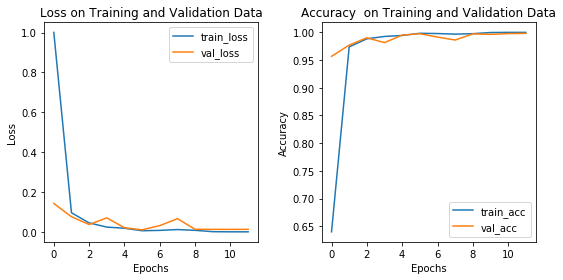

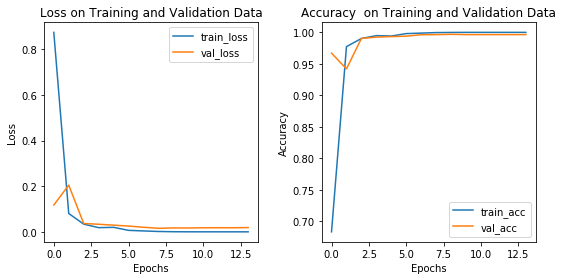

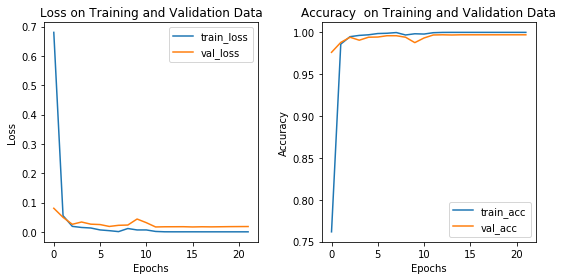

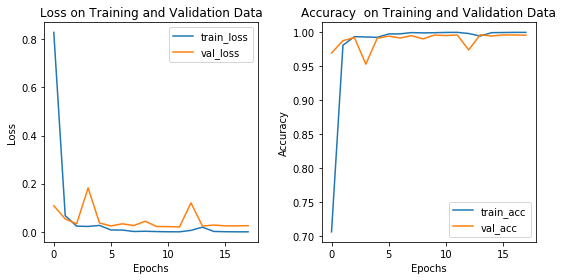

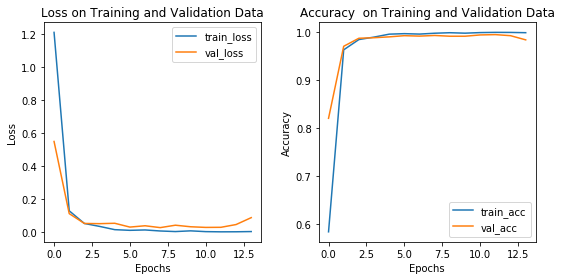

In [22]:
use_cache = 0
if __name__ == '__main__':
    num_folds = 5
    if not os.path.isdir("subm"):
        os.mkdir("subm")
    if not os.path.isdir("cache"):
        os.mkdir("cache")
    if not os.path.isfile("weights/vgg16_weights.h5"):
        print('Please put VGG16 pretrained weights in weights/vgg16_weights.h5')
        exit() 
        
    run_cross_validation_cross_driver(num_folds)    #cross_driver
    run_cross_driver_process_test(num_folds) 
    
    #for i in range(num_folds):
    #    training_vis(hist1_+str(i))
        
    
    #run_cross_validation_separate_driver(num_folds)  #separate_driver
    #run_separate_driver_process_test(num_folds)
    
    #for i in range(num_folds):
    #   training_vis(hist2_+str(i))

In [ ]:
import keras
print (keras.__version__)

